# **Automated DR Classification with PyTorch!**

## Dataset Images

In this section, we are going to:

- Check if dataset in local exists
- Create a method that will plot a random image from our dataset
- Check the properties of our image such as the placing of shapes, preferably change it to [C, H, W]
- Perform basic data augmentation
- Create a `dataset`, and `DataLoader` objects

In [70]:
import torch
from torch import nn
import matplotlib.pyplot as plt
%matplotlib inline

In [71]:
import os
from pathlib import Path

# Check if dataset in local exists
dataset_path = Path(r'./dataset/colored_images/')

if os.path.exists(dataset_path):
    print('Dataset exists.')
else:
    print('Dataset does not exist')

Dataset exists.


In [72]:
import random
import matplotlib.image as mpimg

# Create a method that will plot a random image from our dataset
def plot_random_image(dataset_path: Path = Path(r'./dataset/colored_images/')) -> None:
    """
    Plots a random image from our dataset
    
    Args:
        dataset_path (Path): The directory of the dataset with subfolders as its classification
    
    Returns:
        None
    """
    
    # Get random label
    labels = next(os.walk(dataset_path))[1]
    random_index = random.randint(1, len(labels))
    random_label = labels[random_index]
    
    label_dir = dataset_path / random_label
    
    # Get random image
    random_image = label_dir / random.choice(os.listdir(label_dir))
    
    # Plot the extracted image
    plt.figure()
    
    img = mpimg.imread(random_image)
    imgplot = plt.imshow(img)
    
    plt.title(f'Grade: {random_label} - DR')
    plt.show(imgplot)

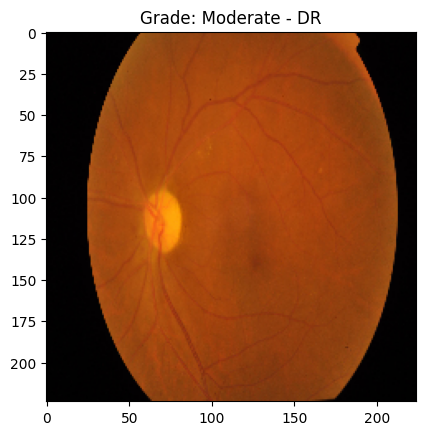

In [73]:
plot_random_image()

In [74]:
# Check the properties of our image, change shape to [C, H, W]

from PIL import Image
import torchvision
from torchvision.transforms import v2

# Get a random image
labels = next(os.walk(dataset_path))[1]
random_index = random.randint(1, len(labels))
random_label = labels[random_index]

label_dir = dataset_path / random_label

random_image_path = label_dir / random.choice(os.listdir(label_dir))

img = Image.open(random_image_path)

transform = v2.Compose([
    v2.PILToTensor(),
    v2.Resize((224,224)),
    v2.ConvertImageDtype(dtype=torch.float32),
    v2.Normalize([0.5,0.5,0.5], [0.5,0.5,0.5])
])

img_tensor = transform(img)

In [75]:
type(img_tensor), img_tensor.shape, img_tensor

(torch.Tensor,
 torch.Size([3, 224, 224]),
 tensor([[[-0.9608, -0.9529, -0.9608,  ..., -0.9451, -0.9451, -0.9451],
          [-0.9686, -0.9608, -0.9451,  ..., -0.9373, -0.9608, -0.9608],
          [-0.9529, -0.9529, -0.9294,  ..., -0.9451, -0.9451, -0.9765],
          ...,
          [-0.9686, -0.9373, -0.9137,  ..., -0.9373, -0.9373, -0.9686],
          [-0.9529, -0.9373, -0.9294,  ..., -0.9373, -0.9529, -0.9529],
          [-0.9451, -0.9294, -0.9451,  ..., -0.9373, -0.9451, -0.9451]],
 
         [[-0.9843, -0.9843, -0.9922,  ..., -0.9765, -0.9765, -0.9686],
          [-0.9922, -0.9843, -0.9765,  ..., -0.9686, -0.9922, -0.9922],
          [-0.9765, -0.9765, -0.9608,  ..., -0.9765, -0.9765, -1.0000],
          ...,
          [-1.0000, -0.9686, -0.9451,  ..., -0.9686, -0.9686, -0.9843],
          [-0.9843, -0.9686, -0.9608,  ..., -0.9686, -0.9843, -0.9765],
          [-0.9765, -0.9608, -0.9765,  ..., -0.9686, -0.9765, -0.9765]],
 
         [[-0.8980, -0.8745, -0.8745,  ..., -0.8667, -0.8

In [76]:
# Create `dataset` object
from torchvision import datasets
from torch.utils.data import random_split

# Create transformation pipelines AND for data augmentation
train_transform = v2.Compose([
    v2.RandomResizedCrop(size=(224, 224), scale=(0.8, 1.0)),
    v2.RandomHorizontalFlip(p=0.5),
    v2.RandomRotation(degrees=15),
    v2.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
    v2.Resize((224,224)),
    v2.ToTensor(),
    v2.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5]),
])

test_transform = v2.Compose([
    v2.Resize((224,224)),
    v2.ToTensor(),
    v2.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
])

full_dataset = datasets.ImageFolder(root=dataset_path)

idx_labels = full_dataset.class_to_idx

# Define train and test size
train_size = int(0.8 * len(full_dataset))
test_size = int(len(full_dataset) - train_size)

# splitting the dataset
train_dataset, test_dataset = random_split(full_dataset, [train_size, test_size])

# applying different transforms
train_dataset.dataset.transform = train_transform
test_dataset.dataset.transform = test_transform


c:\Users\admin\Desktop\Classes\2nd sem\Intelligent Systems\HF Spaces\Diabetic_Retinopathy_Automated_Grading\.venv\Lib\site-packages\torchvision\transforms\v2\_deprecated.py:41: UserWarning: The transform `ToTensor()` is deprecated and will be removed in a future release. Instead, please use `v2.Compose([v2.ToImage(), v2.ToDtype(torch.float32, scale=True)])`.
  warnings.warn(


In [77]:
# See how many images we are dealing with
print(f'Training dataset: {len(train_dataset)}')
print(f'Testing dataset: {len(test_dataset)}')

Training dataset: 2929
Testing dataset: 733


> Before creating a `dataset` object, make sure you have the structure for your dataset:

```
├── train
│   ├── class1
|      ├── 1.jpg
│      ├── 2.jpg
│   ├── class2
|      ├── 1.jpg
│      ├── 2.jpg
├── valid
│   ├── class1
|      ├── 1.jpg
│      ├── 2.jpg
│   ├── class2
|      ├── 1.jpg
│      ├── 2.jpg
```

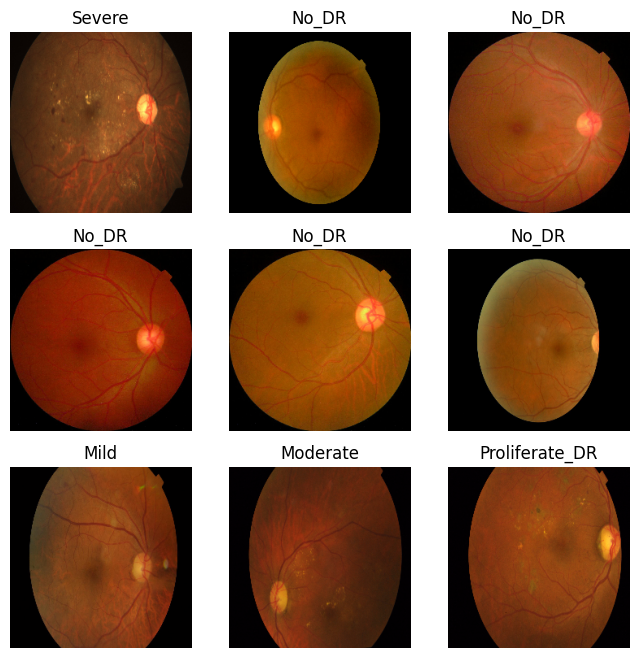

In [78]:
# Visualizing our data

def unnormalize(img, mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5)):
    img = img.clone()  # Avoid modifying original tensor
    for t, m, s in zip(img, mean, std):
        t.mul_(s).add_(m)  # reverse normalization: (img * std) + mean
    return img

figure = plt.figure(figsize=(8, 8))
cols, rows = 3, 3
for i in range(1, cols * rows + 1):
    sample_idx = torch.randint(len(train_dataset), size=(1,)).item()
    img, label = train_dataset[sample_idx]
    img = unnormalize(img) # Unnormalized temporarily for visualization
    figure.add_subplot(rows, cols, i)
    plt.title(list(idx_labels.keys())[list(idx_labels.values()).index(label)])
    plt.axis("off")
    plt.imshow(img.permute(1, 2, 0))
plt.show()

In [79]:
# Create `DataLoader` object

from torch.utils.data import DataLoader

train_dataloader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=64, shuffle=True)

In [80]:
# See dataloader batch data
train_features, train_labels = next(iter(train_dataloader))
print(f"Feature batch shape: {train_features.size()}")
print(f"Labels batch shape: {train_labels.size()}")

# Get single image and label, check their shapes
single_img = train_features[0]
label = train_labels[0]

print(f'Single Image: {single_img.shape}')
print(f'Label: {label}, {type(label)}')

Feature batch shape: torch.Size([64, 3, 224, 224])
Labels batch shape: torch.Size([64])
Single Image: torch.Size([3, 224, 224])
Label: 1, <class 'torch.Tensor'>


## Training

In this section, we are going to:

- Create our Torch class parameters
- Create a method for training and testing our models
- Use visualizations to assess the model

In [90]:
# Creating NN Torch class

class DR_Classifier(nn.Module):
    def __init__(self, input_shape: int, output_shape: int, hidden_units: int = 10):
        super().__init__()
        
        self.block1 = nn.Sequential(
            nn.Conv2d(in_channels=input_shape,
                      out_channels=hidden_units,
                      kernel_size=3,
                      padding=1,
                      ),
            nn.BatchNorm2d(hidden_units),
            nn.LeakyReLU(0.1),
            nn.Conv2d(hidden_units,
                      hidden_units,
                      3,
                      1,
                      1), # These are already in default value, except kernel_size
            nn.BatchNorm2d(hidden_units),
            nn.LeakyReLU(0.1),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Dropout(0.3)
        )
        
        self.block2 = nn.Sequential(
            nn.Conv2d(hidden_units, hidden_units * 2, kernel_size=3, padding=1),
            nn.BatchNorm2d(hidden_units * 2),
            nn.LeakyReLU(0.1),
            nn.Conv2d(hidden_units * 2, hidden_units * 2, kernel_size=3, padding=1),
            nn.BatchNorm2d(hidden_units * 2),
            nn.LeakyReLU(0.1),
            nn.MaxPool2d(2, 2),
            nn.Dropout(0.4)
        )
        
        self.block3 = nn.Sequential(
            nn.Conv2d(hidden_units * 2, hidden_units * 4, kernel_size=3, padding=1),
            nn.BatchNorm2d(hidden_units * 4),
            nn.LeakyReLU(0.1),
            nn.MaxPool2d(2, 2),
            nn.Dropout(0.4)
        )
        
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(hidden_units * 4 * 28 * 28, 512),
            nn.LeakyReLU(0.1),
            nn.Dropout(0.5),
            nn.Linear(512, output_shape)
        )
        
    def forward(self, x):
        x = self.block1(x)
        x = self.block2(x)
        x = self.block3(x)
        x = self.classifier(x)
        return x
    
model_1 = DR_Classifier(input_shape=3, output_shape=len(idx_labels), hidden_units=25)
model_1, model_1.parameters

(DR_Classifier(
   (block1): Sequential(
     (0): Conv2d(3, 25, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
     (1): BatchNorm2d(25, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
     (2): LeakyReLU(negative_slope=0.1)
     (3): Conv2d(25, 25, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
     (4): BatchNorm2d(25, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
     (5): LeakyReLU(negative_slope=0.1)
     (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
     (7): Dropout(p=0.3, inplace=False)
   )
   (block2): Sequential(
     (0): Conv2d(25, 50, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
     (1): BatchNorm2d(50, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
     (2): LeakyReLU(negative_slope=0.1)
     (3): Conv2d(50, 50, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
     (4): BatchNorm2d(50, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
     (5): LeakyReLU(n

In [91]:
# Create a train and testing method
def train_step(model: nn.Module,
               data_loader: torch.utils.data.DataLoader,
               loss_fn: torch.nn.Module,
               optimizer: torch.optim.Optimizer,
               accuracy_fn,
               device
               ) -> None:
    """ 
    Trains the current batch of the `data_loader`.
    
    Args:
        model (nn.Module): A PyTorch model to train your data
        data_loader (DataLoader): The dataloader to train your model
        loss_fn (torch.nn.Module): The loss function to calculate the performance of model
        optimizer (torch.optim.Optimizer): The optimizer to use
        accuracy_fn: Will caculate the accuracy of your model's predictions
        device: Where your data is stored
        
    Returns:
        None
    """
    
    model.to(device)
    train_loss, train_acc = 0, 0
    total_batches = len(data_loader)
    for batch, (X, y) in enumerate(data_loader): 

        X, y = X.to(device), y.to(device)
        
        # Do predictions
        y_pred = model(X)
        
        # Calculate loss
        loss = loss_fn(y_pred, y)
        train_loss += loss.item()
        
        acc = accuracy_fn(y_pred.argmax(dim=1), y)
        train_acc += acc.item()
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        print(f"[Train] Batch {batch + 1}/{total_batches} | Loss: {loss.item():.5f} | Acc: {acc:.2f}% | Images Processed: {len(X)}")
        
    train_loss /= total_batches
    train_acc /= total_batches
    print(f"[Train Summary] Avg Loss: {train_loss:.5f} | Avg Acc: {train_acc:.2f}%\n")
    
def test_step(data_loader: torch.utils.data.DataLoader,
              model: torch.nn.Module,
              loss_fn: torch.nn.Module,
              accuracy_fn,
              device
              ):
    """ 
    Evaluates the current batch of the `data_loader`.
    
    Args:
        model (nn.Module): A PyTorch model to train your data
        data_loader (DataLoader): The dataloader to train your model
        loss_fn (torch.nn.Module): The loss function to calculate the performance of model
        accuracy_fn: Will caculate the accuracy of your model's predictions
        device: Where your data is stored
    
    Returns:
        None
    """
    model.to(device)
    test_loss, test_acc = 0, 0
    total_batches = len(data_loader)
    model.eval()
    with torch.inference_mode():
        for batch, (X, y) in enumerate(data_loader):
            
            X, y = X.to(device), y.to(device)
            
            # Forward pass
            test_pred = model(X)
            
            # Calculate loss and accuracy
            loss = loss_fn(test_pred, y)
            test_loss += loss.item()
            
            acc = accuracy_fn(test_pred.argmax(dim=1), y)
            test_acc += acc.item()
            
            print(f"[Test] Batch {batch + 1}/{total_batches} | Loss: {loss.item():.5f} | Acc: {acc:.2f}% | Images Processed: {len(X)}")

        test_loss /= total_batches
        test_acc /= total_batches
        print(f"[Test Summary] Avg Loss: {test_loss:.5f} | Avg Acc: {test_acc:.2f}%\n")

In [92]:
# Get our device
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model_1.to(DEVICE)

DEVICE

device(type='cpu')

In [93]:
# Setting up optimizer and loss functions
from torchmetrics.classification import Accuracy

loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(params=model_1.parameters(), 
                             lr=0.1)
acc_fn = Accuracy(task="multiclass", num_classes=len(idx_labels))

In [94]:
# Perform a sample prediction before training
with torch.inference_mode():
    # [3, 224, 224] -> [1, 3, 224, 224]
    pred = model_1(single_img.unsqueeze(0)) # Unsqueeze adds another dimension (do not add in dataloaders)
    loss = loss_fn(pred, label.unsqueeze(0))
    
print(f'Actual value: {label}\nPredicted value: {pred.argmax(dim=1).item()} \nLoss: {loss.item()}')

Actual value: 1
Predicted value: 2 
Loss: 2.751321315765381


In [ ]:
# Training our model
EPOCHS = 3

for epoch in range(EPOCHS):
    print(f'Epoch: {epoch+1}\n----------------------------------')
    train_step(
        model=model_1,
        data_loader=train_dataloader,
        loss_fn=loss_fn,
        optimizer=optimizer,
        accuracy_fn=acc_fn,
        device=DEVICE
    )
    
    test_step(
        model=model_1,
        data_loader=test_dataloader,
        loss_fn=loss_fn,
        accuracy_fn=acc_fn,
        device=DEVICE
    )
    
    print(f'-------------------------------------\n\n')

Epoch: 1
----------------------------------
[Train] Batch 1/46 | Loss: 1.69763 | Acc: 0.34% | Images Processed: 64
[Train] Batch 2/46 | Loss: 22273.05078 | Acc: 0.23% | Images Processed: 64
[Train] Batch 3/46 | Loss: 17991.70703 | Acc: 0.47% | Images Processed: 64


## Saving and Loading

In this section, we are going to:

- Save the trained PyTorch model
- Load the PyTorch model
- Perform a basic prediction on the loaded model

In [ ]:
# Saving the trained PyTorch model
MODEL_PATH = Path(r'./dataset')

# Create model save path
MODEL_NAME = "grader.pth"
MODEL_SAVE_PATH = MODEL_PATH / MODEL_NAME

# Save the model state dict
print(f"Saving model to: {MODEL_SAVE_PATH}")

torch.save(obj=model_1.state_dict(), # only saving the state_dict() only saves the learned parameters
           f=MODEL_SAVE_PATH)

Saving model to: dataset\grader.pth


In [ ]:
# Loading the PyTorch model!
loaded_model = DR_Classifier(input_shape=3, 
                                hidden_units=10, # try changing this to 128 and seeing what happens 
                                output_shape=len(idx_labels)) 

# Load in the saved state_dict()
loaded_model.load_state_dict(torch.load(f=MODEL_SAVE_PATH))

# Send model to DEVICE
loaded_model = loaded_model.to(DEVICE)